## Информационная безопасность

**Описание**: Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления анамального и злонамеренного трафика. 

**Задача**: разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный.

**Цель проекта**:

  - Разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как цена ошибки может быть очень высока.
   - оценить качество модели по различным метрикам классификации: precision, recall, f1_score, accuracy.
   - (*) Деплой: разработать REST API сервис, который будет принимать на вход данные трафика и возвращать класс этого трафика.

### Описание признаков:

- Destination Port: указывает номер порта назначения сетевого трафика (категориальный признак)
- Flow Duration: длительность потока (относится к продолжительности сетевого потока) в секундах
- Total Fwd Packets: Представляет общее количество пересылаемых пакетов в потоке.
- Total Backward Packets: Указывает общее количество обратных пакетов в потоке
- Total Length of Fwd Packets, Total Length of Bwd Packets: представляют общую длину (в байтах) всех пересылаемых пакетов и обратных пакетов
- Fwd Packet Length Max (Min, Mean, Std): Represents the maximum length (in bytes) of a single forward packet - максимальную длину (в байтах) одного прямого пакета.
- Bwd Packet Length Max(Min, Mean, Std): Represents the maximum length (in bytes) of a single backward packet - максимальную длину (в байтах) одного обратного пакета
- Flow Bytes/s: Represents the flow rate in bytes per second - скорость потока в байтах в секунду
- Flow Packets/s: Represents the flow rate in packets per second - скорость потока в пакетах в секунду.
- Flow IAT Mean(Std,  Max, Min): Represents the mean interarrival time between two consecutive packets in the flow - среднее время прохождения между двумя последовательными пакетами в потоке.
- Fwd IAT Total(Mean, Std, Max, Min): Represents the total interarrival time between forward packets - общее время прохождения между пересылаемыми пакетами.
- Bwd IAT Total(Mean, Std, Max, Min): Represents the total interarrival time between backward packets - общее время прохождения между обратными пакетами.
- Fwd PSH Flags: Indicates the number of forward packets with the PSH (Push) flag set - количество пересылаемых пакетов с установленным флагом PSH (Push).
- Bwd PSH Flags: Indicates the number of backward packets with the PSH (Push) flag set - количество обратных пакетов с установленным флагом PSH (Push).
- Fwd URG Flags: Indicates the number of forward packets with the URG (Urgent) flag set - количество пересылаемых пакетов с установленным флагом URG (Срочный).
- Bwd URG Flags: Indicates the number of backward packets with the URG (Urgent) flag set - количество обратных пакетов с установленным флагом URG (Срочный).
- Fwd (Bwd) Header Length: Represents the total length of headers in the forward direction -  общую длину заголовков в прямом направлении.

- Fwd (Bwd) Packets/s: Represents the packet rate in the forward direction - скорость передачи пакетов в прямом направлении.
- Min (Max) Packet Length: Represents the minimum length (in bytes) of a packet in the flow - минимальную длину (в байтах) пакета в потоке.
- Packet Length Mean: Represents the mean length (in bytes) of all packets in the flow - среднюю длину (в байтах) всех пакетов в потоке.
- Packet Length Std: Represents the standard deviation of the length (in bytes) of all packets in the flow - стандартное отклонение длины (в байтах) всех пакетов в потоке.
- Packet Length Variance: Represents the variance of the length (in bytes) of all packets in the flow - отклонение длины (в байтах) всех пакетов в потоке.
- FIN Flag Count, SYN..., RST..., PSH..., ACK..., URG..., CWE..., ECE...: Указывает количество пакетов с установленным флагом FIN, SYN......
- Down/Up Ratio: отношение потока вниз по течению к потоку вверх по течению.
- Average Packet Size: средний размер пакета в байтах.
- Avg Fwd Segment Size, Avg Bwd Segment Size: средний размер прямых и обратных сегментов в байтах.
....
----
- Label - классификация трафика

In [1]:
!pip install scikit-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import tensorflow as tf
import keras
import time
import pickle
from IPython.display import display, HTML
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from sklearn.utils import class_weight
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [3]:
import warnings
warnings.filterwarnings("ignore")

Выведем версии библиотек, используемые в проекте для деплоя модели

In [4]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package,
            # not just imported function
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name
imports = list(set(get_imports()))
# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
for r in requirements:
    print("{}=={}".format(*r))

tensorflow==2.5.0
catboost==1.1.1
keras==2.10.0
matplotlib==3.7.1
missingno==0.5.2
numpy==1.23.5
pandas==1.5.3
scikit-learn==1.2.2
scipy==1.10.1
seaborn==0.12.2


Проведём загрузку данных:

In [5]:
df = pd.read_csv('network_traffic_data.csv')

Посмотрим на данные

In [6]:
HTML(df.head().to_html())

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,0,0.000,0.00,0,0,0,0,0,0,72,32,0.547438,0.182479,0,6,2.4,3.287,10.8000,0,0,0,1,0,0,0,0,0,3.00,4.000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,616874,68541.555,71985.97,199836,1,0,0,0,0,296,328,12.640858,14.045398,0,1448,232.6,442.800,196012.6600,0,0,0,1,0,0,0,0,1,244.90,78.100,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,4,4.000,0.00,4,4,0,0,0,0,40,40,13.037980,13.037980,40,112,68.8,39.440,1555.2000,0,0,0,0,0,0,0,0,1,86.00,40.000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,0,0.000,0.00,0,0,0,0,0,0,20,20,17.343046,17.343046,46,128,73.3,47.340,2241.3333,0,0,0,0,0,0,0,0,1,110.00,46.000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,0,0.000,0.00,0,0,0,0,0,0,60,20,3911.342800,1303.781000,6,31,11.0,11.180,125.0000,0,0,0,0,1,0,0,0,0,13.75,14.336,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


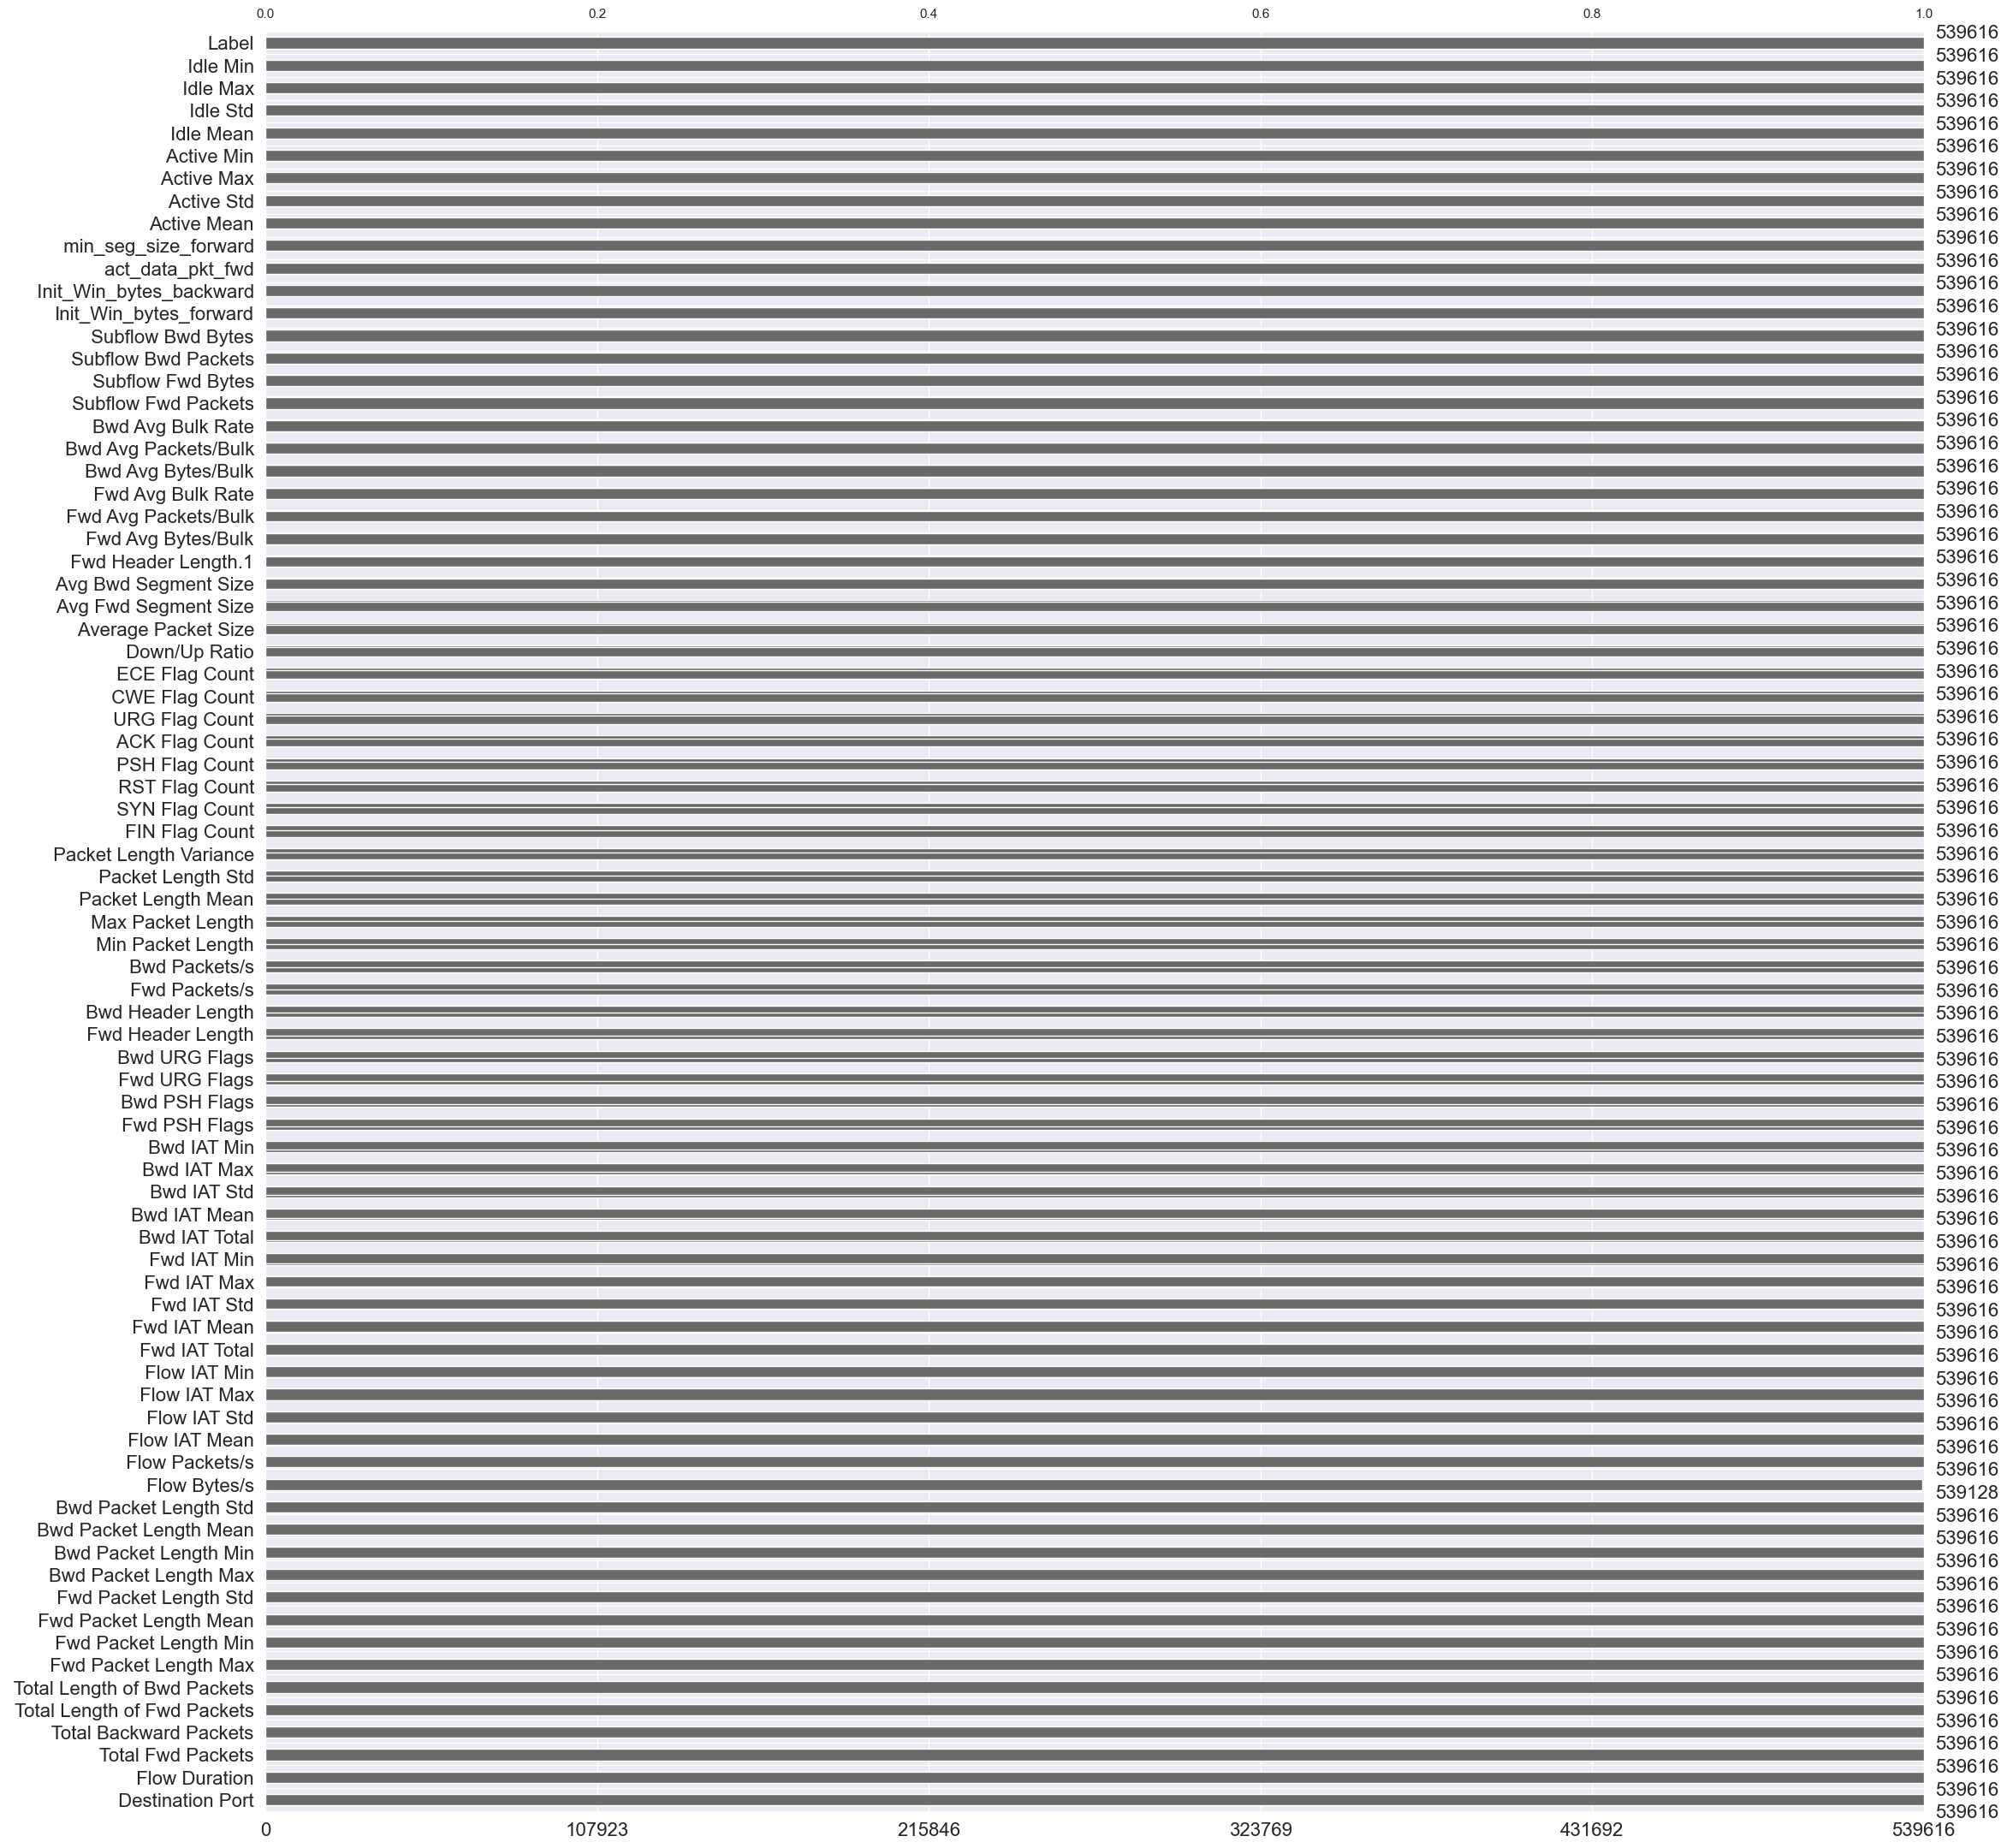

In [7]:
sns.set()
msno.bar(df);

Удалим лишние пробелы из названий признаков и замения пробелы на нижние подчёркивание

In [8]:
df.columns = df.columns.str.strip()

In [9]:
df.columns = df.columns.str.replace(' ', '_')

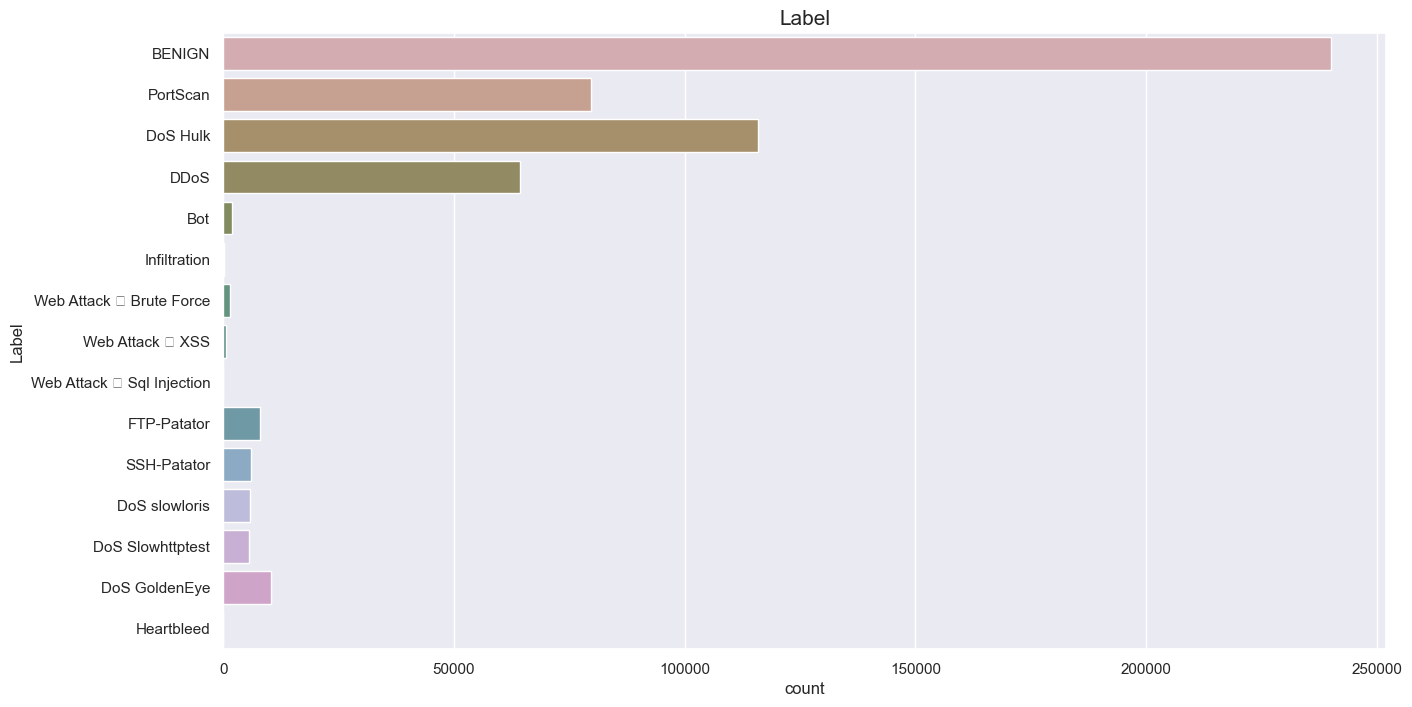

In [10]:
plt.figure(figsize=(15, 8))
sns.countplot(data=df, y='Label', saturation=0.35)
plt.title('Label', fontsize=(15));

В таргете наибольшую долю от всего занимает хороший трафик, остальное распределено между остальными 14-ю классами 

Типы данных которые есть в данных

In [11]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

Как мы видим, всего в данном датасете  до 377731 записей. При этом в столбце Flow Bytes/s записей меньше, а значит есть пропуски. Типы float64(24), int64(54), object(1) - категориальная переменная

In [12]:
def isna_sum(df):
    for col in df.columns.values.tolist():
        if df[col].isna().sum() > 0:
            print('Количество пропусков в столбце: ')
            print(col)
            print(df[col].isna().sum())
            print((round(df[col].isna().sum() / len(df) * 100, 3)), '%')
        else:
            continue

In [13]:
isna_sum(df)

Количество пропусков в столбце: 
Flow_Bytes/s
488
0.09 %


In [14]:
bool_series = pd.isnull(df["Flow_Bytes/s"])  
HTML(df[bool_series].head(5).to_html())

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Total,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Total,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Length,Bwd_Header_Length,Fwd_Packets/s,Bwd_Packets/s,Min_Packet_Length,Max_Packet_Length,Packet_Length_Mean,Packet_Length_Std,Packet_Length_Variance,FIN_Flag_Count,SYN_Flag_Count,RST_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,URG_Flag_Count,CWE_Flag_Count,ECE_Flag_Count,Down/Up_Ratio,Average_Packet_Size,Avg_Fwd_Segment_Size,Avg_Bwd_Segment_Size,Fwd_Header_Length.1,Fwd_Avg_Bytes/Bulk,Fwd_Avg_Packets/Bulk,Fwd_Avg_Bulk_Rate,Bwd_Avg_Bytes/Bulk,Bwd_Avg_Packets/Bulk,Bwd_Avg_Bulk_Rate,Subflow_Fwd_Packets,Subflow_Fwd_Bytes,Subflow_Bwd_Packets,Subflow_Bwd_Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
3492,443,0,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,NaN,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0.0,0.0,0.0,20,0,0,0,0,0,0,1,0,1,0,255,31,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8289,56471,0,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,NaN,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,64,0,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0.0,0.0,0.0,64,0,0,0,0,0,0,2,0,0,0,65535,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
16029,443,0,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,NaN,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,32,32,0.0,0.0,0,0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,1,0.0,0.0,0.0,32,0,0,0,0,0,0,1,0,1,0,472,413,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
18377,443,0,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,NaN,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,40,0,0.0,0.0,0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,0,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
21770,443,0,2,0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,NaN,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,40,0,0.0,0.0,0,0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,40,0,0,0,0,0,0,2,0,0,0,0,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [15]:
df[bool_series]['Label'].unique()

array(['BENIGN', 'DoS Hulk'], dtype=object)

In [16]:
df.query('Label == ["DoS Hulk", "BENIGN"]')['Label'].count()

355974

In [17]:
(df == np.inf).sum().sum()

980

В данных есть строки с бесконечными значениями. Предлагаем создать бесконечность: сравнить с np.inf, посчитать количество True значений и тем самым обнаружить, в каких столбцах они есть и затем заменить бесконечности с помощью метода replace

In [18]:
df.shape

(539616, 79)

In [19]:
HTML(df[(df == np.inf).any(axis=1)].head(5).to_html())

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Total,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Total,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Length,Bwd_Header_Length,Fwd_Packets/s,Bwd_Packets/s,Min_Packet_Length,Max_Packet_Length,Packet_Length_Mean,Packet_Length_Std,Packet_Length_Variance,FIN_Flag_Count,SYN_Flag_Count,RST_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,URG_Flag_Count,CWE_Flag_Count,ECE_Flag_Count,Down/Up_Ratio,Average_Packet_Size,Avg_Fwd_Segment_Size,Avg_Bwd_Segment_Size,Fwd_Header_Length.1,Fwd_Avg_Bytes/Bulk,Fwd_Avg_Packets/Bulk,Fwd_Avg_Bulk_Rate,Bwd_Avg_Bytes/Bulk,Bwd_Avg_Packets/Bulk,Bwd_Avg_Bulk_Rate,Subflow_Fwd_Packets,Subflow_Fwd_Bytes,Subflow_Bwd_Packets,Subflow_Bwd_Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
2023,443,0,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,6,6,6.000,0.000,0.000000,0,0,0,0,1,0,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,255,513,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3199,44511,0,1,1,6,2,6,6,6.0,0.0,2,2,2.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,24,0.0,0.0,2,6,4.668,2.309,5.333334,1,0,0,0,1,0,0,0,1,7.0,6.0,2.0,20,0,0,0,0,0,0,1,6,1,2,0,1024,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3492,443,0,1,1,0,0,0,0,0.0,0.0,0,0,0.0,0.0,NaN,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,0,0,0.000,0.000,0.000000,0,0,0,0,1,0,0,0,1,0.0,0.0,0.0,20,0,0,0,0,0,0,1,0,1,0,255,31,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6409,443,0,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,40,0,0.0,0.0,6,6,6.000,0.000,0.000000,1,0,0,0,0,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,0,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7883,80,0,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,inf,inf,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,0.0,0.0,6,6,6.000,0.000,0.000000,0,0,0,0,1,0,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,16425,913,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [20]:
df[(df == np.inf).any(axis=1)]['Label'].value_counts()

DoS Hulk       447
BENIGN         200
PortScan        73
Bot             10
FTP-Patator      3
DDoS             1
Name: Label, dtype: int64

В данных у присутствуют бесконечные значения в столбцах Flow Bytes/s и Flow Packets/s и они присутствуют в довольно часто встречающихся класса, BENIGN, PortScan, Bot, FTP-Patator и DDoS замени эти значения на nan, далее попробуем заполнить эти значения.

In [21]:
df = df.replace([np.inf, -np.inf], np.nan)

In [22]:
(df == np.inf).sum().sum()

0

### -----

Напишем функцию, которая будет заполнять пропуски в колонках "Flow Bytes/s" и "Flow Packets/s" медианами, исходя из класса в колонке "Label".

In [23]:
numeric_columns = ['Flow_Bytes/s', 'Flow_Packets/s']

In [24]:
def fill_na_with_medians(df, label_column, numeric_columns):
    for column in numeric_columns:
        for label in df[label_column].unique():
            median = df[df[label_column] == label][column].median()
            df.loc[(df[column].isna()) & (df[label_column] == label), column] = median
    return df

In [25]:
df = fill_na_with_medians(df, 'Label', numeric_columns)


In [26]:
df.isna().sum().sum()

0

Проверим как заполнились значения:

In [27]:
df[numeric_columns].loc[[2023, 3199, 3492, 6409, 7883]]

,Flow_Bytes/s,Flow_Packets/s
2023,5163.359471,122.571551
3199,5163.359471,122.571551
3492,5163.359471,122.571551
6409,5163.359471,122.571551
7883,5163.359471,122.571551


In [28]:
HTML(df.describe(include='all').to_html())

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Total,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Total,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Length,Bwd_Header_Length,Fwd_Packets/s,Bwd_Packets/s,Min_Packet_Length,Max_Packet_Length,Packet_Length_Mean,Packet_Length_Std,Packet_Length_Variance,FIN_Flag_Count,SYN_Flag_Count,RST_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,URG_Flag_Count,CWE_Flag_Count,ECE_Flag_Count,Down/Up_Ratio,Average_Packet_Size,Avg_Fwd_Segment_Size,Avg_Bwd_Segment_Size,Fwd_Header_Length.1,Fwd_Avg_Bytes/Bulk,Fwd_Avg_Packets/Bulk,Fwd_Avg_Bulk_Rate,Bwd_Avg_Bytes/Bulk,Bwd_Avg_Packets/Bulk,Bwd_Avg_Bulk_Rate,Subflow_Fwd_Packets,Subflow_Fwd_Bytes,Subflow_Bwd_Packets,Subflow_Bwd_Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
count,539616.000000,5.396160e+05,539616.000000,539616.000000,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,539616.000000,539616.0,539616.000000,539616.0,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,5.396160e+05,539616.0,539616.0,539616.0,539616.0,539616.0,539616.0,539616.000000,5.396160e+05,539616.000000,5.396160e+05,539616.000000,539616.000000,539616.000000,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,539616
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240000
mean,5563.061394,2.106693e+07,6.119972,5.985495,4.082371e+02,7.999779e+03,169.449966,11.855382,44.681011,59.525095,1675.074384,23.508936,550.037006,697.306414,1.085478e+06,7.924558e+04,2.134902e+06,5.264535e+06,1.731840e+07,2.945584e+05,2.075634e+07,4.036797e+06,6.666492e+06,1.720041e+07,1.035760e+06,9.601754e+06,2.028745e+06,2.413091e+06,6.464188e+06,8.147788e+05,0.036747,0.0,0.000056,0.0,-4.593957e+03,-4.290450e+03,7.142149e+04,7.885307e+03,9.609552,1723.695630,276.581177,544.090932,1.112688e+06,0.062524,0.036747,0.000120,0.377765,0.365884,0.060567,0.000056,0.000120,0.643446,305.358765,44.681011,550.037006,-4.593957e+03,0.0,0.0,0.0,0.0,0.0,0.0,6.119972,4.082371e+02,5.985495,7.9987

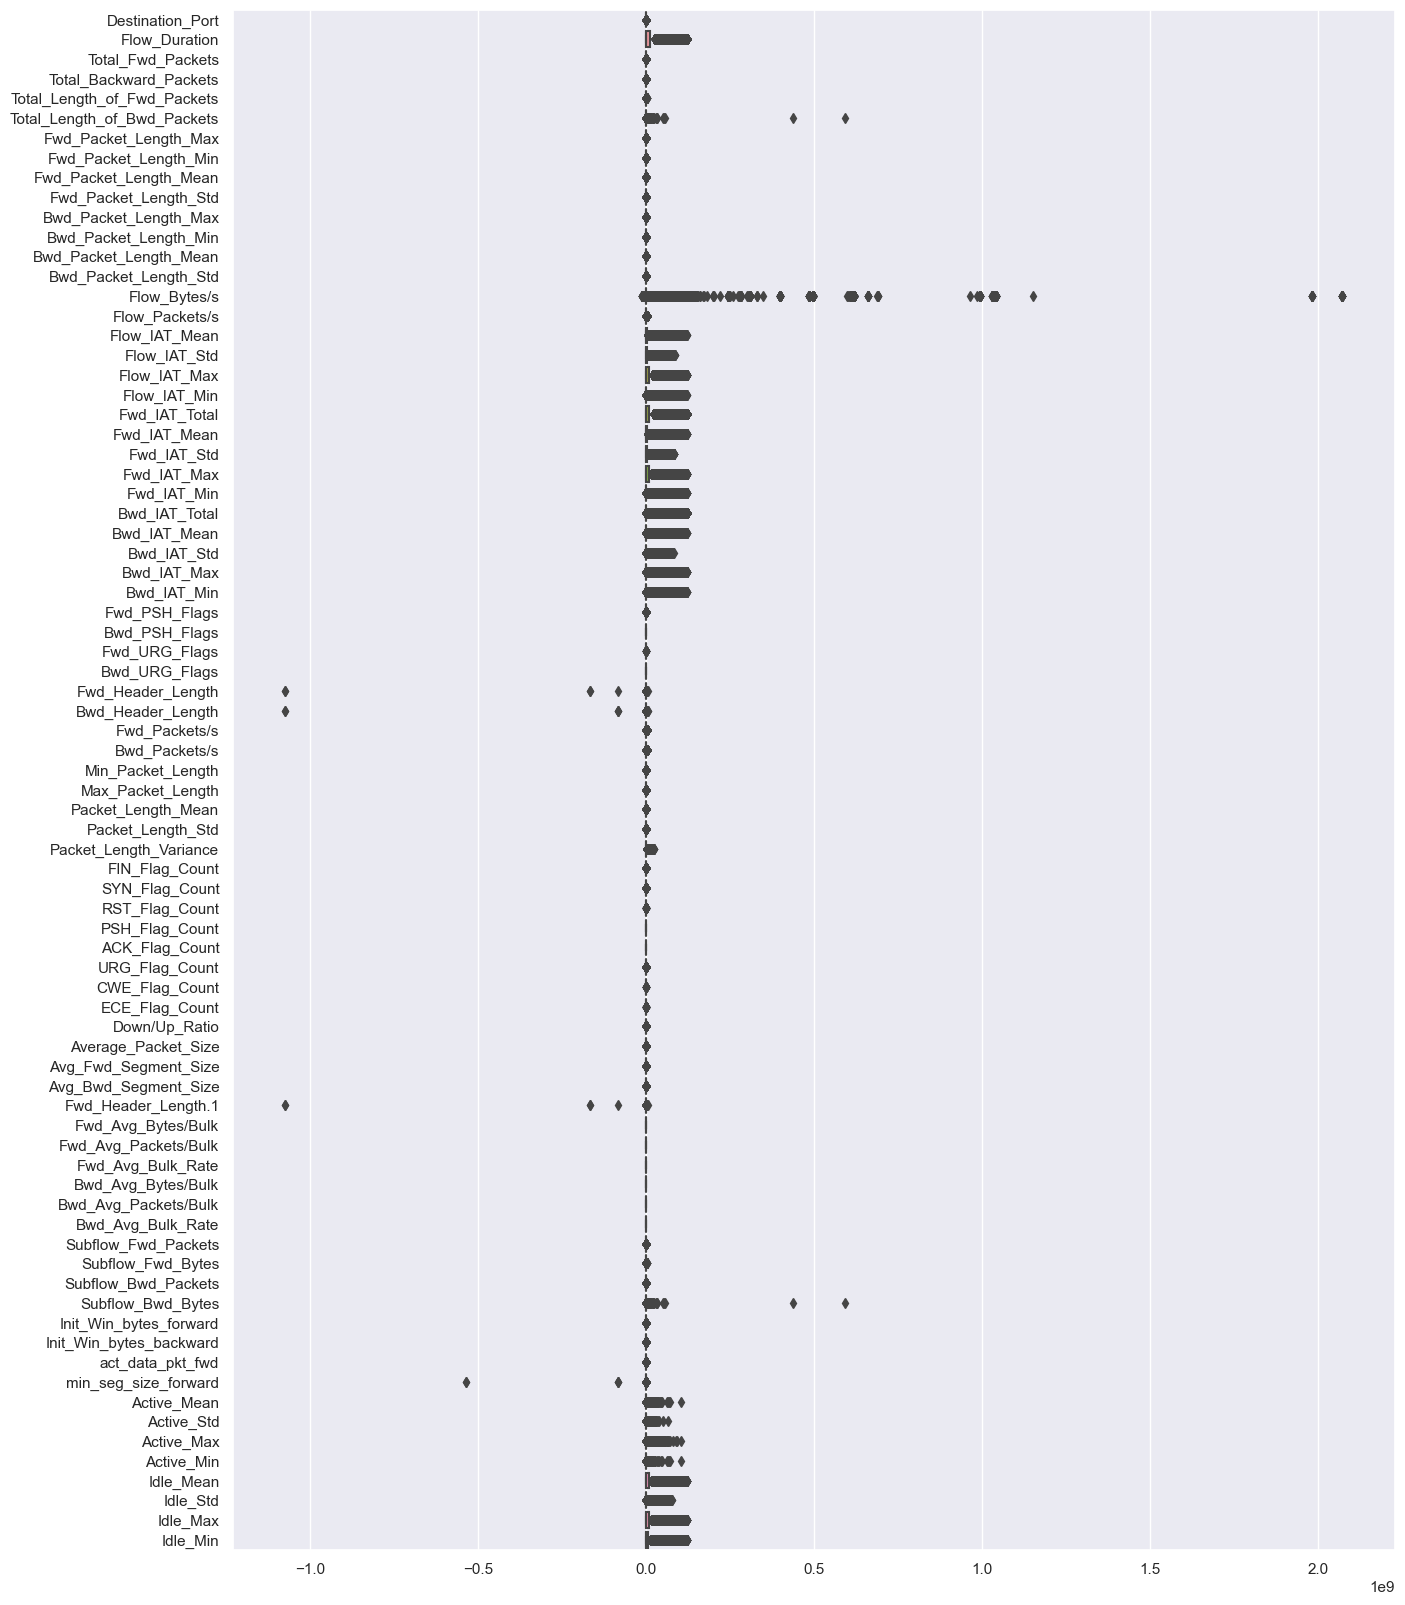

In [29]:
plt.figure(figsize=(15, 20))
sns.boxplot(data=df, orient='h');

In [30]:
df[['Total_Length_of_Bwd_Packets', 'Flow_Bytes/s', \
'Fwd_Header_Length', 'Bwd_Header_Length', \
'Fwd_Header_Length.1','Subflow_Bwd_Bytes', \
'min_seg_size_forward']].describe()

,Total_Length_of_Bwd_Packets,Flow_Bytes/s,Fwd_Header_Length,Bwd_Header_Length,Fwd_Header_Length.1,Subflow_Bwd_Bytes,min_seg_size_forward
count,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05
mean,7.999779e+03,1.085478e+06,-4.593957e+03,-4.290450e+03,-4.593957e+03,7.998768e+03,-2.429314e+03
std,1.014442e+06,2.411698e+07,2.095355e+06,2.076610e+06,2.095355e+06,1.013814e+06,1.052329e+06
min,0.000000e+00,-1.200000e+07,-1.073741e+09,-1.073741e+09,-1.073741e+09,0.000000e+00,-5.368707e+08
25%,0.000000e+00,1.022615e+02,4.000000e+01,2.000000e+01,4.000000e+01,0.000000e+00,2.000000e+01
50%,1.050000e+02,2.240584e+03,6.400000e+01,4.000000e+01,6.400000e+01,1.050000e+02,2.400000e+01
75%,8.216250e+03,1.250000e+05,1.640000e+02,1.360000e+02,1.640000e+02,8.216250e+03,3.200000e+01
max,5.910000e+08,2.071000e+09,4.173072e+06,5.413720e+06,4.173072e+06,5.905961e+08,1.380000e+02


Нами были загруженны данные в которых имеется 78 колонок с признаками входящего трафика и целевой признак, который представлен 15-тью категориями из которых BENIGN - это хороший трафик, а остальные  14 категорий злонамеренный трафик.  Была проведена замена бесконечных и Nan значений, затем мы заполнили эти значения на медианные исходя из медиан по классам к которым относились данные значения. В данных присутствуют выбросы, их не так много, но удалять мы их будем только из обучающей выборки, чтобы модель смогла достичь лучшего качества при обучении. Приступим к разбиению частей датафрейма.

### Разбиение на train, valid, test

Выделим категориальные признаки, численные признаки и разделим данные для обучения

In [34]:
cat_features = ['Destination_Port']

In [35]:
X = df.drop('Label', axis=1)
y = df['Label']

Отделим тестовую часть, чтобы после обучения моделей посмотреть на оценку качества моделей реально.  Будем использовать стратификацию по таргету.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

Проверим дисбаланс классов в обучающей и тестовой выборках

In [37]:
display(y_train.value_counts())
y_test.value_counts()

BENIGN                        144000
DoS Hulk                       69584
PortScan                       47796
DDoS                           38619
DoS GoldenEye                   6176
FTP-Patator                     4763
SSH-Patator                     3538
DoS slowloris                   3477
DoS Slowhttptest                3299
Bot                             1180
Web Attack � Brute Force         904
Web Attack � XSS                 391
Infiltration                      22
Web Attack � Sql Injection        13
Heartbleed                         7
Name: Label, dtype: int64

BENIGN                        96000
DoS Hulk                      46390
PortScan                      31864
DDoS                          25747
DoS GoldenEye                  4117
FTP-Patator                    3175
SSH-Patator                    2359
DoS slowloris                  2319
DoS Slowhttptest               2200
Bot                             786
Web Attack � Brute Force        603
Web Attack � XSS                261
Infiltration                     14
Web Attack � Sql Injection        8
Heartbleed                        4
Name: Label, dtype: int64

Отделим от тестовой части валидационную для выбора лучшей модели

In [38]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, \
                                                    y_test, test_size=0.5, \
                                                    stratify=y_test, random_state=42)

In [39]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((323769, 78), (323769,), (107924, 78), (107924,), (107923, 78), (107923,))

Ранее мы смотрели на данные и обнаружили выбросы по некоторым столбцам, рассмотрим их сейчас, когда разделили данные, так как мы не можем улучшать наблюдения в валиде и трейне. Обработаем только сильные выбросы, применим метод Winsorizing

Winsorizing — это метод обработки выбросов, который включает замену экстремальных значений ближайшим неэкстремальным значением. Это можно сделать с помощью функции scipy.stats.mstats.winsorize()   Мы видим, что экстремальные значения были заменены ближайшим неэкстремальным значением. Winsorizing может быть полезен, когда мы хотим сохранить общее распределение данных при удалении экстремальных значений.

In [31]:
col_not = ['Total_Length_of_Bwd_Packets', 'Flow_Bytes/s', \
'Fwd_Header_Length', 'Bwd_Header_Length', \
'Fwd_Header_Length.1', 'Subflow_Bwd_Bytes', \
'min_seg_size_forward'] 

In [32]:
for col in X_train[col_not]: 
     X_train[col] = stats.mstats.winsorize(X_train[col], limits=[0.1, 0.2])
X_train[col_not].describe()

,Total_Length_of_Bwd_Packets,Flow_Bytes/s,Fwd_Header_Length,Bwd_Header_Length,Fwd_Header_Length.1,Subflow_Bwd_Bytes,min_seg_size_forward
count,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000
mean,3204.719947,48922.937800,91.517972,75.969582,91.517972,3204.719947,26.124881
std,4944.605590,68316.776560,62.766400,75.107284,62.766400,4944.605590,5.762754
min,0.000000,0.000000,24.000000,0.000000,24.000000,0.000000,20.000000
25%,0.000000,102.261516,40.000000,20.000000,40.000000,0.000000,20.000000
50%,105.000000,2240.584307,64.000000,40.000000,64.000000,105.000000,24.000000
75%,8216.250000,125000.000000,164.000000,136.000000,164.000000,8216.250000,32.000000
max,11595.000000,163265.306100,192.000000,200.000000,192.000000,11595.000000,32.000000


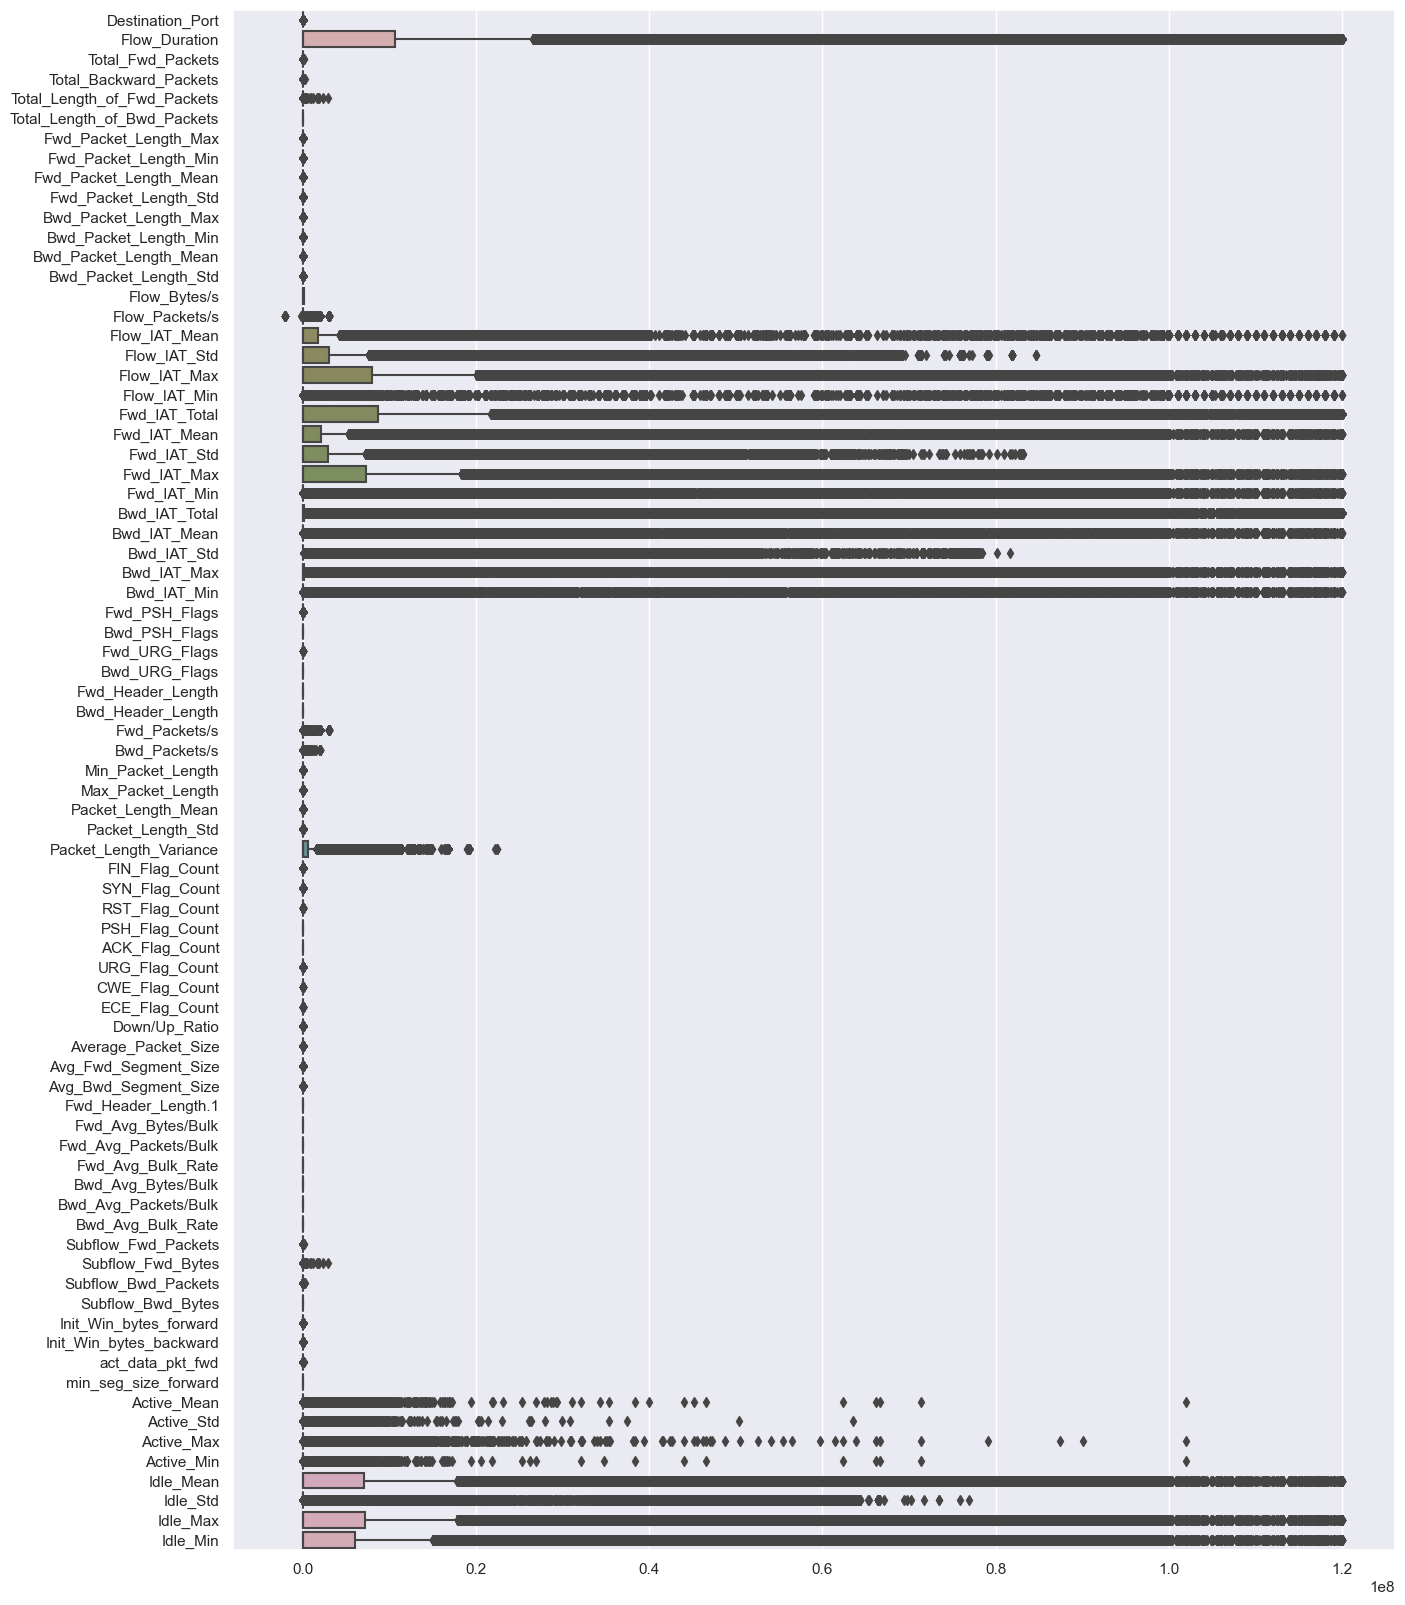

In [33]:
plt.figure(figsize=(15, 20))
sns.boxplot(data=X_train, orient='h', saturation=0.35);

Удалим явные дубликаты  в train:

In [53]:
# Объединение X_train и y_train в один датафрейм
train_data = pd.concat([X_train, y_train], axis=1)

In [54]:
train_data.duplicated().sum()

33284

In [44]:
# Удаление явных дубликатов по столбцам в X_train и соответствующих строк в y_train
train_data_cleaned = train_data.drop_duplicates()

In [45]:
# Разделение train_data_cleaned обратно на X_train и y_train
X_train = train_data_cleaned.iloc[:, :-1]
y_train = train_data_cleaned.iloc[:, -1:]

In [55]:
print('Количество: ', X_train.duplicated().sum())

Количество:  0


#### RandomForestClassifier 

In [43]:
# Создание и обучение модели случайного леса
model = RandomForestClassifier(n_estimators=20, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, n_jobs=-1)

In [44]:
# Предсказание классов на валидационных  данных
y_pred = model.predict(X_valid)

In [49]:
print(classification_report(y_valid, y_pred)) 

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     48000
                       Bot       0.95      0.96      0.95       393
                      DDoS       1.00      1.00      1.00     12874
             DoS GoldenEye       1.00      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     23195
          DoS Slowhttptest       1.00      1.00      1.00      1100
             DoS slowloris       1.00      0.99      1.00      1159
               FTP-Patator       1.00      1.00      1.00      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       1.00      1.00      1.00     15932
               SSH-Patator       1.00      1.00      1.00      1180
  Web Attack � Brute Force       0.73      0.83      0.78       301
Web Attack � Sql Injection       0.50      0.25

In [46]:
feature_imp = pd.Series(model.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp.head(10)

Packet_Length_Mean             0.075014
Packet_Length_Std              0.060285
Avg_Bwd_Segment_Size           0.057610
Fwd_Packet_Length_Max          0.047263
Packet_Length_Variance         0.046330
Subflow_Fwd_Bytes              0.044158
Total_Length_of_Bwd_Packets    0.042525
Fwd_Packet_Length_Mean         0.032737
Destination_Port               0.032713
Init_Win_bytes_forward         0.032487
dtype: float64

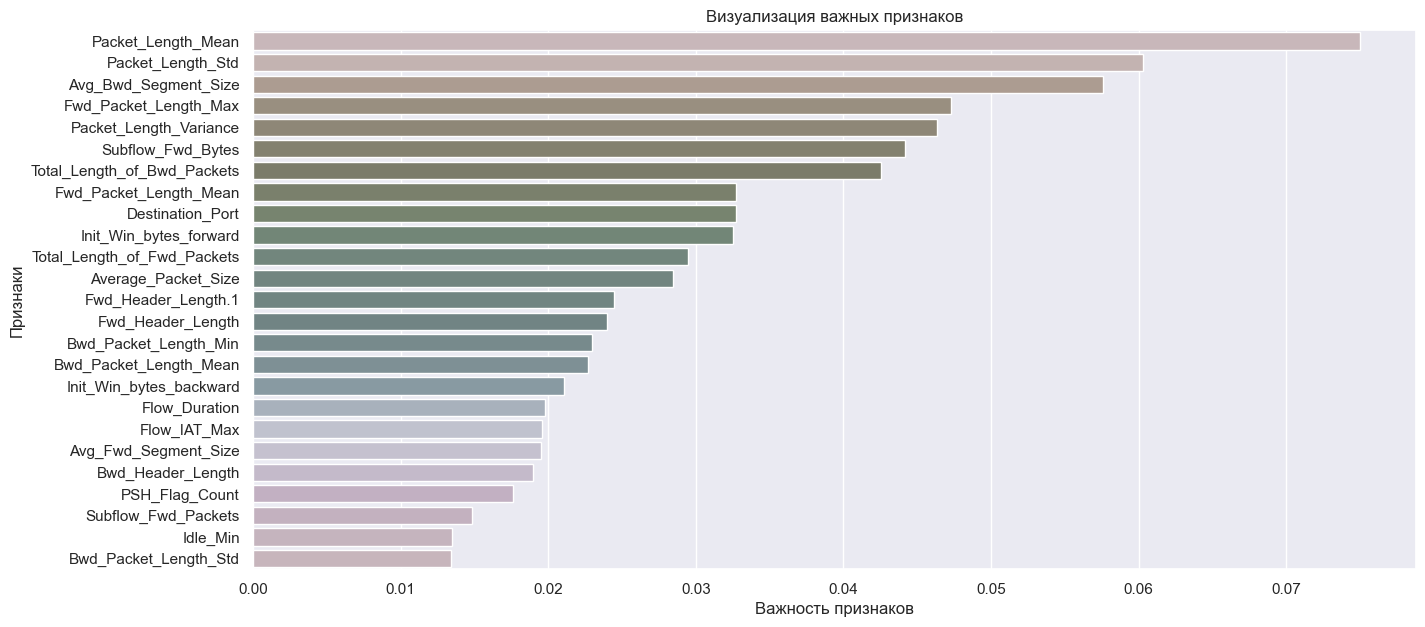

In [47]:
plt.figure(figsize=(15, 7))
sns.barplot(x=feature_imp.head(25), y=feature_imp.index[:25], saturation=0.15)

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

Модель показала не плохие результаты на валидации. Роль в обучении играют почти все признаки в больше или меньшей степени, часть их не была выведена, так как имеют не большой вес. Улучшим модель и сравним метрики с учётом весов модели 

#### RandomForestClassifier +  class_weight

In [48]:
model_balans = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
model_balans.fit(X_train, y_train)
# Предсказание классов на валидационных  данных
y_pred_balans = model_balans.predict(X_valid)

In [52]:
# Вычисление метрик
print(classification_report(y_valid, y_pred_balans))  

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     48000
                       Bot       0.95      0.98      0.96       393
                      DDoS       1.00      1.00      1.00     12874
             DoS GoldenEye       1.00      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     23195
          DoS Slowhttptest       1.00      1.00      1.00      1100
             DoS slowloris       1.00      0.99      1.00      1159
               FTP-Patator       1.00      1.00      1.00      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       1.00      1.00      1.00     15932
               SSH-Patator       1.00      1.00      1.00      1180
  Web Attack � Brute Force       0.73      0.79      0.76       301
Web Attack � Sql Injection       0.50      0.25

Метрики с использованием  class_weight немного улучшились, но попробуем подобрать параметры с использованием RandomizedSearchCV

#### RandomForestClassifier + RandomizedSearchCV

In [82]:
%%time

param_dist = {"max_depth": [20, 100],                     # Предоставленный список
              "max_features": randint(1, 11),          # Данное распределение
              "min_samples_split": randint(2, 11),     # Данное распределение
              "bootstrap": [True, False],                 # Предоставленный список
              "criterion": ["gini", "entropy"]}           # Предоставленный список

# Используем RandomSearch + CV для выбора гиперпараметров
n_iter_search = 20
random_search = RandomizedSearchCV(model_balans,\
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_params_


CPU times: total: 4min 56s
Wall time: 14min 31s


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 10,
 'min_samples_split': 5}

In [50]:
%%time
# Создание и обучение модели случайного леса


model_rs = RandomForestClassifier(n_jobs=-1, class_weight="balanced",
                                  bootstrap=True, criterion='gini',
                                  max_depth=90, max_features=10,
                                  min_samples_split=5)
model_rs.fit(X_train, y_train)

CPU times: total: 4min 16s
Wall time: 24.3 s


RandomForestClassifier(class_weight='balanced', max_depth=90, max_features=10,
                       min_samples_split=5, n_jobs=-1)

In [51]:
# Предсказание классов на валидационных  данных
y_pred_rs = model_rs.predict(X_valid)

In [45]:
# Вычисление метрик
print(classification_report(y_valid,  y_pred_rs)) 

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     48000
                       Bot       0.95      0.96      0.96       393
                      DDoS       1.00      1.00      1.00     12874
             DoS GoldenEye       1.00      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     23195
          DoS Slowhttptest       1.00      1.00      1.00      1100
             DoS slowloris       1.00      0.99      1.00      1159
               FTP-Patator       1.00      1.00      1.00      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       1.00      1.00      1.00     15932
               SSH-Patator       1.00      1.00      1.00      1180
  Web Attack � Brute Force       0.74      0.83      0.78       301
Web Attack � Sql Injection       0.50      0.25

C использованием подбора метрики немного улучшилимь, перейдём к модели CatBoost

#### CatBoostClassifier

In [71]:
%%time

model_cat = CatBoostClassifier(thread_count=-1, iterations=100)
model_cat.fit(X_train, y_train, cat_features=cat_features, verbose=20)

Learning rate set to 0.5
0:	learn: 0.4207937	total: 1.66s	remaining: 2m 44s
20:	learn: 0.0330427	total: 33.2s	remaining: 2m 4s
40:	learn: 0.0179907	total: 1m 3s	remaining: 1m 31s
60:	learn: 0.0134354	total: 1m 36s	remaining: 1m 1s
80:	learn: 0.0104062	total: 2m 12s	remaining: 31.1s
99:	learn: 0.0094002	total: 2m 48s	remaining: 0us
CPU times: total: 27min 4s
Wall time: 2min 49s


In [72]:
y_pred_cat = model_cat.predict(X_valid)

In [55]:
# Вычисление метрик
print(classification_report(y_valid, y_pred_cat))

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     48000
                       Bot       0.94      0.99      0.96       393
                      DDoS       1.00      1.00      1.00     12874
             DoS GoldenEye       1.00      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     23195
          DoS Slowhttptest       0.99      0.99      0.99      1100
             DoS slowloris       0.99      0.99      0.99      1159
               FTP-Patator       1.00      1.00      1.00      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       1.00      1.00      1.00     15932
               SSH-Patator       1.00      1.00      1.00      1180
  Web Attack � Brute Force       0.72      0.94      0.81       301
Web Attack � Sql Injection       0.67      0.50

В этой модели recall  f1-score по классу  Web Attack � Brute Force улучшились, однако остальные показатели немного ниже чем в модели случайного леса со случайным подбором, посмотрим на важность признаков.

In [56]:
feature_imp_cat = pd.Series(model_cat.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp_cat.head(10)

Destination_Port           41.459601
Init_Win_bytes_backward    10.013429
Bwd_IAT_Mean                7.644084
Fwd_Packets/s               6.765690
Fwd_IAT_Min                 5.897706
Init_Win_bytes_forward      3.294744
PSH_Flag_Count              2.568173
Avg_Fwd_Segment_Size        2.058512
Fwd_Header_Length.1         1.912527
Average_Packet_Size         1.855282
dtype: float64

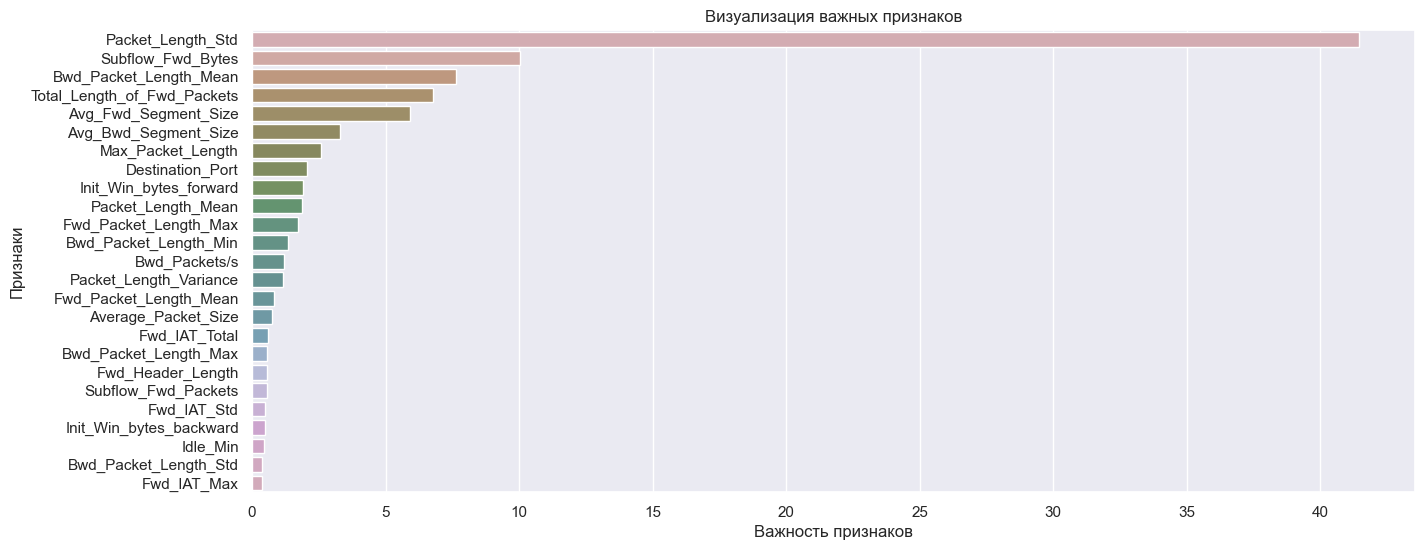

In [106]:
feature_imp_cat = pd.Series(model_cat.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp_cat.head(10)
plt.figure(figsize=(15, 6))
sns.barplot(x=feature_imp_cat.head(25), y=feature_imp.index[:25], saturation=0.35)

plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков')
plt.show()

Распределение важности признаков похоже, как и у в моделях случайного леса, однако в модели CatBoost большой удельный вес имеет признак с Packet_Length_Std - стандартная длина пакета

#### CatBoostClassifier + RandomizedSearchCV

In [58]:
%%time
model_cat_rs = CatBoostClassifier(loss_function='MultiClass', verbose=False, thread_count=-1)
param_grid = {'learning_rate': uniform(0.1),
              'depth': randint(3, 20),
              'iterations': randint(10, 110),
              
}

random_search = RandomizedSearchCV(model_cat_rs,
                                   param_distributions=param_grid, 
                                   cv=3, 
                                   n_iter=10)

random_search.fit(X_train, y_train, cat_features=cat_features)

In [59]:
# Выводим лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

In [ ]:
# Получаем лучшую модель
best_model_cat = random_search.best_estimator_

In [ ]:
%%time
y_pred_cat_rs = best_model_cat.predict(X_valid)

In [70]:
# Вычисление метрик
print(classification_report(y_valid, y_pred_cat_rs))

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     48000
                       Bot       0.94      0.98      0.96       393
                      DDoS       1.00      1.00      1.00     12874
             DoS GoldenEye       0.99      1.00      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     23195
          DoS Slowhttptest       0.99      0.99      0.99      1100
             DoS slowloris       0.99      0.99      0.99      1159
               FTP-Patator       1.00      1.00      1.00      1588
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       1.00      1.00      1.00     15932
               SSH-Patator       1.00      1.00      1.00      1180
  Web Attack � Brute Force       0.71      0.96      0.82       301
Web Attack � Sql Injection       0.50      0.25

качество модели при подборе оказалось меньше, чем с дефолтными значениями, попробуем применить class_weight

#### CatBoostClassifier + class_weight

In [109]:
X_train_seq = X_train.values  # Матрица признаков без последней колонки
y_train_seq = y_train.values  # Вектор таргетов

In [113]:
# Создание объекта LabelEncoder
label_encoder = LabelEncoder()

# Преобразование строковых значений таргета в числовые индексы
y_encoded = label_encoder.fit_transform(y_train_seq)

# Преобразование таргета в one-hot кодировку
y_onehot_train = tf.keras.utils.to_categorical(y_encoded, num_classes=15)

In [114]:
# Вычисление весов классов
class_weights =class_weight.compute_class_weight(class_weight = "balanced", \
                                                 classes = np.unique(y_train_seq), y = y_train_seq)
class_weights_dict = dict(enumerate(class_weights))

In [115]:
class_weights_dict

{0: 0.14989305555555554,
 1: 18.292033898305085,
 2: 0.5589114166601932,
 3: 3.494915803108808,
 4: 0.3101948723844562,
 5: 6.54277053652622,
 6: 6.20782283577797,
 7: 4.531723703548184,
 8: 3083.5142857142855,
 9: 981.1181818181818,
 10: 0.45159846012218596,
 11: 6.100791407574901,
 12: 23.876769911504425,
 13: 1660.3538461538462,
 14: 55.203580562659845}

In [116]:
# Преобразование строковых значений таргета в числовые индексы
y_encoded_valid = label_encoder.transform(y_valid.values)

# Преобразование таргета в one-hot кодировку
y_onehot_valid = tf.keras.utils.to_categorical(y_encoded_valid, num_classes=15)

y_encoded_test = label_encoder.transform(y_test.values)

# Преобразование таргета в one-hot кодировку
y_onehot_test = tf.keras.utils.to_categorical(y_encoded_test, num_classes=15)

In [117]:
%%time

model_cat_weights = CatBoostClassifier(verbose=False, class_weights=class_weights_dict, thread_count=-1)
model_cat_weights.fit(X_train, y_encoded)

CPU times: total: 2h 34min 8s
Wall time: 15min 19s


In [ ]:
y_pred_cat_weights = model_cat_weights.predict(X_valid)

In [119]:
# Вычисление метрик
print(classification_report(y_encoded_valid, y_pred_cat_weights))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     48000
           1       0.63      1.00      0.77       393
           2       1.00      1.00      1.00     12874
           3       0.98      1.00      0.99      2059
           4       0.99      1.00      1.00     23195
           5       0.98      1.00      0.99      1100
           6       0.99      0.99      0.99      1159
           7       1.00      1.00      1.00      1588
           8       0.33      1.00      0.50         2
           9       0.06      0.57      0.11         7
          10       1.00      1.00      1.00     15932
          11       0.99      1.00      0.99      1180
          12       0.72      0.70      0.71       301
          13       0.27      0.75      0.40         4
          14       0.32      0.45      0.37       130

    accuracy                           0.99    107924
   macro avg       0.75      0.90      0.79    107924
weighted avg       0.99   

при использовании  class_weight немного подросли показатели по классу  14 - Web Attack � XSS , но уменьшились по остальным мало представленным классам, поэтому принимаем решение использовать модель CatBoost

#### тестирование

In [60]:
# Предсказание классов на валидационных  данных
y_pred_test = model_cat.predict(X_test)
print(classification_report(y_test, y_pred_test))  

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     48000
                       Bot       0.95      0.96      0.96       393
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       0.99      1.00      1.00      2058
                  DoS Hulk       1.00      1.00      1.00     23195
          DoS Slowhttptest       0.99      0.99      0.99      1100
             DoS slowloris       0.99      0.99      0.99      1160
               FTP-Patator       1.00      1.00      1.00      1587
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.86      0.92         7
                  PortScan       1.00      1.00      1.00     15932
               SSH-Patator       1.00      1.00      1.00      1179
  Web Attack � Brute Force       0.71      0.93      0.80       302
Web Attack � Sql Injection       0.67      1.00

In [62]:
model_cat.save_model('catboost_model_ml.cbm')

Мы провели загрузку и анализ данных, выявили пропуски и бесконечные значения, которые были обработаны и заменены на медианные значения пропорционально классам к которым они относились. Для предсказания классов трафиков нами были использованны два вида моделеймашинного обучения:
- RandomForestClassifier
- CatBoostClassifier
Мы улучшали и сравнивали модели по метрикам. Улучшения пытались достичь за счёт использования разделения выборок с указанием таргета,  class_weight и подбор оптимальных параметров с помощью  RandomizedSearchCV.  По моделям метрики:
- accuracy  ≈ 1.00, 
- macro avg   ≈ 0.90,
- weighted avg  ≈ 1.00

Решающим выбором модели стали лучшие метрики полученные на валидационной выборке:
- precision    
- recall  
- и f1-score по трём видам злонамеренного трафика:
     - Web Attack � Brute Force
     - Web Attack � Sql Injection
     - Web Attack � XSS, которые представлены в данных в небольшом количестве, поэтом умоделям трудно выучить зависимости.
Выбор итоговой модели мы остановили на CatBoost.  Метрики полученные в данной работе не являются показательными и в дальнейшем возможно их улучшить используя более подходящую модель с оптимально подобранными параметрами или если есть возможность, то надо дополнить данные наблюдениями по малопредставленным классам. 